### LangGraph

Imagine scheduling a doctor’s appointment where an AI agent checks your calendar, accesses your provider’s system, verifies insurance, and confirms everything in one go.

A Multi-agent systems as above require more advanced frameworks which provide the infrastructure for coordinating autonomous agents, managing communication and resources, and orchestrating workflows.

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.
It uses graph-based architecture that handles complex processes and maintains context across agent interactions.

LangGraph is similar to n8n for building AI based workflows.

Since, LangGraph uses graph-based architecture there are 3 main componnets to it -
- State – A shared data structure that represents the current snapshot of your application.
    - A reducer is a small function that tells LangGraph how to merge updates into state when multiple nodes return values.
- Nodes – Python functions that encode the logic of your agents.
- Edges – Python functions that determine which Node to execute next based on the current state. They can be conditional branches or fixed transitions.

In [1]:
# Let's start with a simple app where we have certain tools availbale and the llm decides
# on the fly which one to use

# https://python.langchain.com/docs/integrations/tools/

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.invoke("LangChain")

"Page: LangChain\nSummary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.\n\n"

In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [3]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()
tavily.invoke("Provide me the recent AI news for August 27th 2025")

/var/folders/p5/5wwxls6d0_7f88w12nqn06080000gp/T/ipykernel_75910/1303346446.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


[{'title': 'AI News Wrap-Up: 27th August 2025 | AI Assistant Store',
  'url': 'https://www.aiassistantstore.com/blogs/latest-news/ai-news-wrap-up-27th-august-2025',
  'content': 'All AI Under One Roof™\n\n## Country/region\n\n## Country/region\n\n## Language\n\n## Language\n\nAI Assistant Store\n\n## Item added to your cart\n\nAI News Wrap-Up: 27th August 2025\n\n# AI News Wrap-Up: 27th August 2025\n\n### 🛡 Anthropic Sets Up National Security AI Advisory Council [...] Anthropic has pulled together a new National Security and Public Sector Advisory Council - made up of ex-lawmakers, intel veterans, and security pros - to weigh in on how AI gets used inside U.S. government work. The timing follows its recent $200M Pentagon deal, underscoring just how strategic AI has become.  \n🔗 Read more\n\n### 👾 Claude AI Blocks Hacker Exploits [...] ### ✈ IFA 2025: Flying Taxis, Retail Shake-ups & More\n\nBerlin’s IFA 2025 (Sep 5–9) is looking very AI-heavy - think Microsoft’s e-commerce push, invisi

In [4]:
### Combine all the tools in the list

tools=[wiki,tavily]

In [5]:
## Initialize my LLM model

from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-5-2025-08-07")
llm_with_tools=llm.bind_tools(tools)

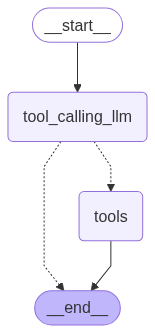

In [6]:
# next we start creating our graph

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# The first thing we do in a graph is to define the state
# In LangGraph, the "state" is a dictionary-like object that flows through your graph. It carries all the data you want to persist between nodes.
# as graph runs we want messages to be appended to the state for that we will use the add_messages reducer
# that appends messages to the list of messages in the state
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

### Node definition
# state["messages"] is the imcoming message to LLM and the output is the response from LLM appended to the messages list
# Because of the Annotated[..., add_messages] in the State, LangGraph knows to append this message to the running messages list, not overwrite it.
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 2 recent AI news for August 27th 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 2 recent AI news for August 27th 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Jfk5FcMs0Riu8gYn3iwBcNWv)
 Call ID: call_Jfk5FcMs0Riu8gYn3iwBcNWv
  Args:
    query: August 27, 2025 AI news
  tavily_search_results_json (call_ATd638RPa87TajbCakf7PRSm)
 Call ID: call_ATd638RPa87TajbCakf7PRSm
  Args:
    query: Aug. 27, 2025 artificial intelligence news
  tavily_search_results_json (call_ZlW4u5bOrCe8TTV3BZU3M2Vh)
 Call ID: call_ZlW4u5bOrCe8TTV3BZU3M2Vh
  Args:
    query: 2025-08-27 AI news OpenAI Google Anthropic
  tavily_search_results_json (call_DJCWUFcD1VVB0j7jgkg6WeWd)
 Call ID: call_DJCWUFcD1VVB0j7jgkg6WeWd
  Args:
    query: August 27, 2025 AI policy regulation news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top AI Ne

In [8]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

Machine learning is a branch of artificial intelligence where computers learn patterns from data to make predictions or decisions without being explicitly programmed with rules.

How it works (at a high level):
- Collect data (labeled or unlabeled) and define the task.
- Choose a model and a loss/objective function.
- Train the model by optimizing the loss on training data (often with gradient descent).
- Validate on held-out data to tune settings and avoid overfitting; test and deploy.
- Monitor performance over time as data changes.

Main types:
- Supervised learning: learn from labeled examples (e.g., regression, classification).
- Unsupervised learning: find structure in unlabeled data (e.g., clustering, dimensionality reduction).
- Reinforcement learning: learn by trial and error to maximize rew

### ReAct agent architecture
What if the LLM need to use multiple tools based on prompt like "Get the google dodole for the day and info about it from wikipedia"

This is a general agent architecture with 3 important steps
- Act -> The LLM model calling a specifc tool in above scenrio. i,e, based on input the model does something.
- Observe -> Once tool executes it does not end the execution but will send the response back to the model
- Reason -> Model will reason again about the output from the tool and decide the next step

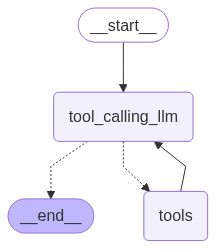

In [9]:
# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
messages=graph.invoke({"messages":HumanMessage(content="Find information on the Eiffel Tower. First, use Tavily Search to get the most recent news or updates. Then, use Wikipedia to provide historical or background details. Combine both sources in your final answer.")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Find information on the Eiffel Tower. First, use Tavily Search to get the most recent news or updates. Then, use Wikipedia to provide historical or background details. Combine both sources in your final answer.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_BuVw0Do8SRYmP0uSOrxRsrpI)
 Call ID: call_BuVw0Do8SRYmP0uSOrxRsrpI
  Args:
    query: Eiffel Tower latest news updates 2025
  wikipedia (call_ivHRz5sq4itAGf5Ik4EyJREO)
 Call ID: call_ivHRz5sq4itAGf5Ik4EyJREO
  Args:
    query: Eiffel Tower
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Like a hanging garden on the 1st floor of the Eiffel Tower", "url": "https://www.toureiffel.paris/en/news/visit/hanging-garden-1st-floor-eiffel-tower", "content": "From May 28 to September 15, 2025, the Eiffel Tow

### Debugging
We can debug langgraph apps using langGraph studio

File openai_agent.py



`langgraph dev`

### Workflows patterns + RAG + Human in the loop

https://langchain-ai.github.io/langgraph/tutorials/workflows/

https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/